In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import dtale
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from prince import MCA
from prince import FAMD

In [2]:
df = pd.read_csv('tedsd_puf_2019.csv')

## Select Columns

##### Drop Unnecessary

In [3]:
#Unnecessary columns
df = df.drop(columns=['DISYR','CASEID','CBSA2010','DETCRIM','PREG','DAYWAIT','SERVICES_D','EMPLOY_D','LIVARAG_D','ARRESTS_D',
                     'DETNLF_D','SUB3','SUB3_D','ROUTE3','FREQ3','FREQ3_D','FRSTUSE3','FREQ_ATND_SELF_HELP_D'])

#High missing data counts
df = df.drop(columns=['DETNLF','PRIMINC','SUB2','SUB2_D','ROUTE2','FREQ2','FREQ1_D','FREQ2_D','FRSTUSE2','HLTHINS','PRIMPAY'])

#Drop substance flag columns
df = df.drop(columns=['ALCFLG','COKEFLG', 'MARFLG', 'HERFLG', 'METHFLG', 'OPSYNFLG', 'PCPFLG',
                      'HALLFLG', 'MTHAMFLG', 'AMPHFLG', 'STIMFLG', 'BENZFLG', 'TRNQFLG',
                      'BARBFLG', 'SEDHPFLG', 'INHFLG', 'OTCFLG', 'OTHERFLG'])

In [4]:
df.head()

,STFIPS,EDUC,MARSTAT,SERVICES,LOS,PSOURCE,NOPRIOR,ARRESTS,EMPLOY,METHUSE,...,SUB1,SUB1_D,ROUTE1,FREQ1,FRSTUSE1,FREQ_ATND_SELF_HELP,DIVISION,REGION,IDU,ALCDRUG
0,2,4,1,7,37,1,0,0,2,2,...,2,2,1,2,5,1,9,4,0,1
1,2,3,1,7,35,1,0,0,1,2,...,2,2,1,2,3,1,9,4,0,3
2,2,2,1,7,35,1,0,0,4,2,...,2,2,1,2,2,1,9,4,0,3
3,2,3,1,7,37,1,1,0,3,2,...,2,2,1,1,3,4,9,4,0,3
4,2,3,3,7,37,1,1,0,4,2,...,2,2,1,1,7,1,9,4,0,1


##### Drop NaN

In [5]:
df = df.replace(-9, np.nan) #Replace coded missing values

In [6]:
df.isna().sum() #Count NaN values per column

STFIPS                      0
EDUC                   174935
MARSTAT                360937
SERVICES                    0
LOS                         0
PSOURCE                120477
NOPRIOR                136613
ARRESTS                182116
EMPLOY                 152365
METHUSE                178805
PSYPROB                225375
GENDER                    756
VET                    174003
LIVARAG                174307
REASON                      0
DSMCRIT                410311
AGE                         0
RACE                    58924
ETHNIC                  60872
SUB1                    99426
SUB1_D                 217220
ROUTE1                 142828
FREQ1                  196872
FRSTUSE1               150579
FREQ_ATND_SELF_HELP    327054
DIVISION                    0
REGION                      0
IDU                    131797
ALCDRUG                     0
dtype: int64

In [7]:
df_drop = df.dropna()
print('Values dropped:')
len(df) - len(df_drop)

Values dropped:


1029980

In [8]:
print('States lost:')
len(df['STFIPS'].unique()) - len(df_drop['STFIPS'].unique())

States lost:


11

## Feature Engineering

#### Norm Mean of LOS

In [9]:
#Change LOS categories to minimum of range
df_drop.loc[df_drop['LOS'] == 32, 'LOS'] = 46
df_drop.loc[df_drop['LOS'] == 33, 'LOS'] = 61
df_drop.loc[df_drop['LOS'] == 34, 'LOS'] = 91
df_drop.loc[df_drop['LOS'] == 35, 'LOS'] = 121
df_drop.loc[df_drop['LOS'] == 36, 'LOS'] = 181
df_drop.loc[df_drop['LOS'] == 37, 'LOS'] = 366

service_mean = pd.DataFrame(df_drop.groupby('SERVICES')['LOS'].mean())
service_mean['SERVICE']=service_mean.index

service_mean_dict = pd.Series(service_mean.LOS.values, index=service_mean.SERVICE).to_dict()

df_drop['LOSmean'] = df_drop['SERVICES']
df_drop = df_drop.replace({'LOSmean':service_mean_dict})

df_drop['LOSnorm'] = df_drop['LOS']/df_drop['LOSmean']
df_drop = df_drop.drop(columns=['LOSmean'])

#### Binary Discharge Status

In [10]:
df_drop.loc[df_drop['REASON'] == 1, 'REASONbinary'] = 1
df_drop.loc[df_drop['REASON'] !=1, 'REASONbinary'] = 0

In [11]:
df_drop.columns

Index(['STFIPS', 'EDUC', 'MARSTAT', 'SERVICES', 'LOS', 'PSOURCE', 'NOPRIOR',
       'ARRESTS', 'EMPLOY', 'METHUSE', 'PSYPROB', 'GENDER', 'VET', 'LIVARAG',
       'REASON', 'DSMCRIT', 'AGE', 'RACE', 'ETHNIC', 'SUB1', 'SUB1_D',
       'ROUTE1', 'FREQ1', 'FRSTUSE1', 'FREQ_ATND_SELF_HELP', 'DIVISION',
       'REGION', 'IDU', 'ALCDRUG', 'LOSnorm', 'REASONbinary'],
      dtype='object')

#### Create Dummy Variable DF for Categories

In [12]:
df_dummies = pd.get_dummies(df_drop, prefix='', prefix_sep='',
                           columns=['STFIPS', 'EDUC', 'MARSTAT', 'SERVICES', 'LOS', 'PSOURCE', 'NOPRIOR',
                                   'ARRESTS', 'EMPLOY', 'METHUSE', 'PSYPROB', 'GENDER', 'VET', 'LIVARAG',
                                   'REASON', 'DSMCRIT', 'AGE', 'RACE', 'ETHNIC', 'SUB1', 'SUB1_D',
                                   'ROUTE1', 'FREQ1', 'FRSTUSE1', 'FREQ_ATND_SELF_HELP', 'DIVISION',
                                   'REGION', 'IDU', 'ALCDRUG'])

In [13]:
df_dummies.head()

,LOSnorm,REASONbinary,1,2,5,8,9,10,11,13,...,0,1,2,3,4,0.0,1.0,1,2,3
0,4.637621,1.0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0
1,1.533203,0.0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,1
2,1.533203,0.0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,1
3,4.637621,1.0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,1
4,4.637621,0.0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0


## Multiple Correspondence Analysis (MCA)

In [14]:
df_categories = df_drop.applymap(str) #Make all columns strings
df_categories['LOSnorm'] = pd.to_numeric(df_categories['LOSnorm'])

<AxesSubplot:title={'center':'Row and column principal coordinates'}, xlabel='Component 0 (1.17% inertia)', ylabel='Component 1 (1.00% inertia)'>

findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.


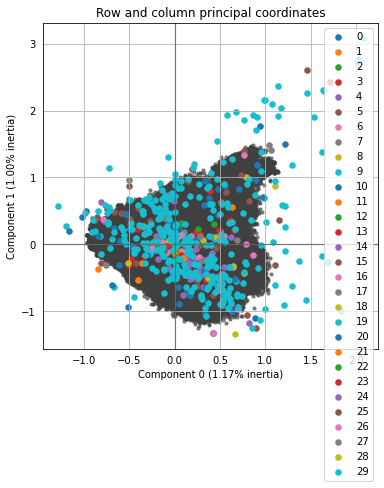

In [15]:
%matplotlib inline

x = df_categories.loc[:, df_categories.columns != 'REASONbinary'].values

y = df_categories.loc[:, ['REASONbinary']].values

mca = MCA(n_components=5, n_iter=3, random_state=101)
principalComponents = mca.fit_transform(x)

mca.plot_coordinates(X=x)

## Factor Analysis of Mixed Data (FAMD)

In [16]:
df_categories = df_drop.applymap(str)
df_categories['LOSnorm'] = pd.to_numeric(df_categories['LOSnorm'])

In [17]:
famd = FAMD(n_components=2, n_iter=3, random_state=101)

famd.fit(df_categories.drop('SERVICES', axis=1))
famd.fit_transform(df_categories)

,0,1
0,2.215342,-0.788072
1,0.360871,-0.879542
2,0.402163,-0.842727
3,2.201931,-0.704148
4,2.169187,-0.531279
...,...,...
1722488,0.211557,-1.320462
1722490,-0.030544,-0.933506
1722492,0.038268,-1.335027
1722493,-0.139175,-0.399486


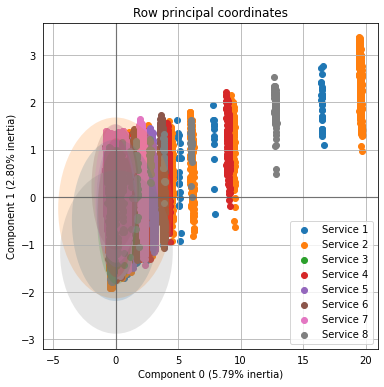

In [18]:
ax = famd.plot_row_coordinates(df_categories,color_labels=['Service {}'.format(t) for t in df_categories['SERVICES']])

## PCA on Reduced Set with Dummy Variables

#### Binary Status as Y

In [19]:
x = df_dummies.loc[:, df_dummies.columns != 'REASONbinary'].values

y = df_dummies.loc[:, ['REASONbinary']].values

x = StandardScaler().fit_transform(x)

([<matplotlib.axis.XTick at 0x1dd68cfcac0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

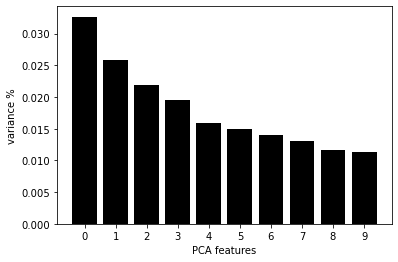

In [20]:
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(x)

features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

Text(0, 0.5, 'PCA 2')

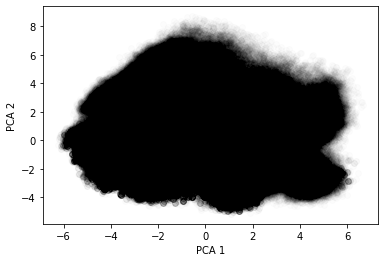

In [21]:
PCA_components_df = pd.DataFrame(principalComponents)

plt.scatter(PCA_components_df[0], PCA_components_df[1], alpha=.01, color='black') #Alpha reduced to look for clustering
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

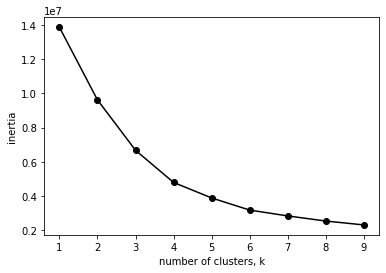

In [22]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components_df.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [23]:
pca = (PCA(n_components=2))

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
                          , columns = ['PC1','PC2'])

finalDf = pd.concat([principalDf, df_drop[['REASONbinary']]], axis=1)

(-7.5, 7.5)

findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.


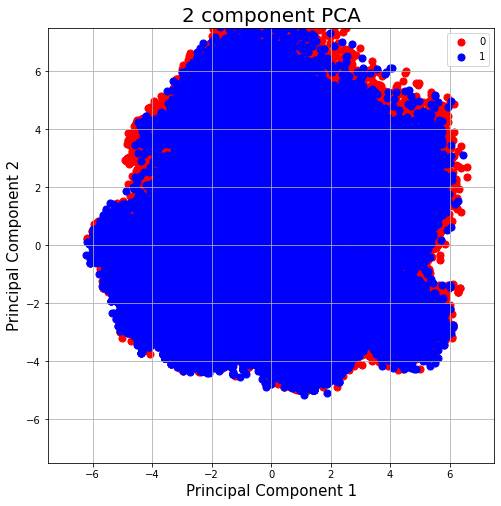

In [24]:
%matplotlib inline

fig = plt.figure(figsize =(8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1]

colors = ['r','b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['REASONbinary'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

ax.set_xlim([-7.5,7.5])
ax.set_ylim([-7.5,7.5])

#### LOSnorm as Y

In [25]:
x = df_dummies.loc[:, df_dummies.columns != 'LOSnorm'].values

y = df_dummies.loc[:, ['LOSnorm']].values

x = StandardScaler().fit_transform(x)

([<matplotlib.axis.XTick at 0x1dd65b2c790>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

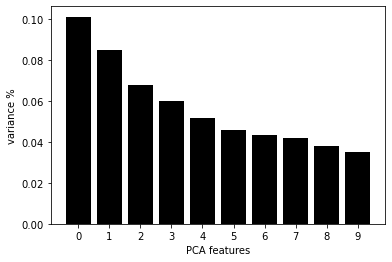

In [26]:
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(x)

features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

Text(0, 0.5, 'PCA 2')

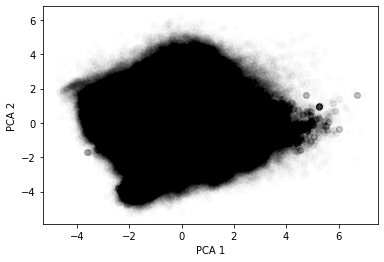

In [27]:
PCA_components_df = pd.DataFrame(principalComponents)

plt.scatter(PCA_components_df[0], PCA_components_df[1], alpha=.01, color='black') #Alpha reduced to look for clustering
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

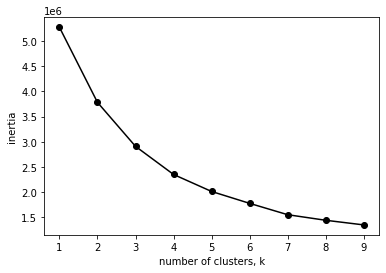

In [28]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components_df.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()